Principles
===

## HFIR

> This section covers the calibration for HFIR powder diffraction instruments, including HB-2A and HB-2C.This section covers the calibration for HFIR powder diffraction instruments, including HB-2A and HB-2C.

### Howto

> A side note would be that for constant wavelength (CW) instruments, the calibration can be vaguely considered as part of the data analysis step. The reason is that in terms of technical barrier, it is relatively easier for general users or instrument scientists to grab the diffraction data for those standard samples, load them into a Ritveld program and perform the calibration, by releasing those calibration relevant parameters (e.g., zero offset). This is in contrast to the calibration for time-of-flight (TOF) instruments, as to be discussed in details in the section below.

For both HB-2A and HB-2C, they are running the constant wavelength mode, and specifically they have the monochromator wavelength as follows,

- HB-2A: 1.54 Å, 2.41 Å, 1.12 Å (Information can be found [https://neutrons.ornl.gov/powder](https://neutrons.ornl.gov/powder))

- HB-2C: 1.5 Å, 0.95 Å (Information can be found at [https://neutrons.ornl.gov/wand](https://neutrons.ornl.gov/wand))

Both instruments then use standard sample to perform the calibration in Rietveld programs (Fullprof, GSAS, and GSAS-II) to generate the instrument parameter, which not only contains the calibration constant but also hosts the instrument peak profile information. Specifically,

- HB-2A has been using multiple standard samples as the calibrants, namely Si, Lab6, and NAC (Na2Al2Ca3F14). The instrument parameter files suitable for multiple Rietveld programs for those various calibrants can be found at [https://neutrons.ornl.gov/powder/users](https://neutrons.ornl.gov/powder/users).

- HB-2C has been using Si as the calibrant, and also the instrument parameter files for various Rietveld programs are provided, as can be found at [https://neutrons.ornl.gov/wand/users](https://neutrons.ornl.gov/wand/users).

### Usage

On the user side, it is expected that the instrument parameter files should be delivered to them together with the user data so that they can import those instrument parameter file in relevatnt Rietveld programs to conduct the refinement. At this point, specifically for CW data, the main wavelength (corresponding to the monochromator used during the experiment) should be read in from the instrument parameter file, leaving the zero offset refinable.

## SNS

> This section covers the calibration for SNS powder diffraction instruments, including NOMAD and POWGEN.

### Howto - principle

> Compared to constant wavelength (CW) instruments, the calibration for time-of-flight (TOF) instruments is a bit more complicated. The main reason is that both NOMAD and POWGEN are not only generating Bragg diffraction data but also at the same time they would be used to produce the total scattering data (the Fourier transform of which would yield the pair distribution function (PDF) for probing the local structure of materials). The comlexity in terms of calibration then comes on the total scattering side, as detailed below.

> The principle covered in the context below applies to both NOMAND and POWGEN -- it fact, it should be applied in general to all the powder TOF diffractometers, at least in principle. However, for the moment, the implementation is only done on NOMAD. For POWGEN, the calibration routine will be covered in its own dedicated section below.

The calibration for NOMAD and POWGEN can be roughly separated into two scenarios -- one for the generation of total scattering data and the other for the Bragg diffraction pattern. For the Bragg part, the mechanism of calibration is similar to that for CW instruments, in terms of technical operation. First, a standard sample (Si, Lab6, or NAC) needs to be measured and the corresponding Bragg pattern would be loaded into Rietveld program where the calibration parameters would be released for being refined, including the DIFC, DIFA, TZERO parameters (specifically for POWGEN, one also has an extra DIFB parameter). The refined calibration constants for various banks (on NOMAD, usuaslly the physical banks would be used to group the spectra from the individual detectors whereas for POWGEN, usually there is only one bank) would then be written into the instrument parameter file along with those instrument peak profile parameters.

On the total scattering side, the calibration is more of a part of the data reduction process since it is a prerequisite to produce the total scattering in $Q$-space (followed by the Fourier transform to produce the PDF). The principle of calibration stays the same -- a standard sample would be measured and the TOF-to-$d$ transformation relation would be constructed against those known peak positions in $d$-space. Usually, a diamond sample would be used for such a calibration purpose on both NOMAD and POWGEN, since the sharp and strong diamond diffraction peaks makes it easy to perform the peak fitting for extracting the peak position accurately. In practice, a generic routine has been designed to routinely calibrate the instrument, by performing sequentially an automatic grouping of pixels (using an unsupervised clustering algorithm), cross correlation, and the actual calibration steps. The automatic grouping step can be summarized as below,

<img src="../../imgs/calib_grouping.png" alt="drawing" width="1200"/>

where the scattering patterns from all detectors would be clustered into different groups so that each group contains patterns as similar to each other as possible. The purpose of such an automatic grouping step is for identifying the outlier pixels (thus considered being masked). Depending on the clustering algorithm being used, the way of pixels being identified as outliers is a bit different. For example, with `KMEANS` method, all pixels will be included in the final grouping (thus no outliers by default). In this case, if we increase the number of groups to be identified, we would have groups with few pixels generated, and if we set a upper limit for the acceptable number of pixels in a single group, we could mask all the pixels involved in those groups with the number of pixels smaller than the specified threshold.

Next, the diamond (220) peak will be used as the reference, and we will first calculate the offset of the corresponding peak for each pixel, as compared to the nominal diamond (220) peak position. The offset then could be translated into an effective DIFC value and be applied to the loaded diamond dataset. Converting unit to d-space using this updated DIFC value should give one an initial calibrated lining-up of all the pixels.# Using the diamond (220) peak as the reference , we will first calculate the offset of the corresponding peak for each pixel. The offset then could be translated into an effective DIFC value and be applied to the loaded diamond dataset. Converting unit to d-space using this updated DIFC value should give one an initial calibrated lining-up of all the pixels, as demonstrated in the picture below,

<img src="../../imgs/calib_cc.png" alt="drawing" width="1200"/>

> The lattice parameter for diamond at room temperature was calculated from the following paper:

> DOI: 10.1103/PhysRevLett.104.085901

> The value was calculated to be 3.5671299351 angstrom and accordingly the nominal position of diamond (hkl) peaks can be calculated following formula, d_spacing = latt / sqrt(h^2 + k^2 + l^2)

The final stage of the generic calibration routine is to bring the peak position of the focused pattern to its nominal position. This step involves the peak fitting (multiple peaks could be used) to extract the peak position in TOF-space, and then by comparing to the nominal peak positions of the standard sample, the TOF-to-$d$ transformation relation could be established using a combination of parameters including DIFA, DIFC, and TZERO parameters, by assuming the following relation between TOF and $d$,

As a showcase, the following picture is showing the result of applying such a generic calibration routine on NOMAD (left -- alignment of pixels using the engineering values, i.e., $L_1$, $L_2$ and scattering angle, right -- alignment after calibration),

<img src="../../imgs/calib_final.png" alt="drawing" width="1200"/>

As a quantitative diagnostic, the following figure is showing the difference between the calibrated and nominal diamond peak positions -- here we are taking NOMAD as the demo case and the result shown is for the back scattering bank (which is with the highest resolution among all the 6 physical banks),

<img src="../../imgs/Bank_5_d_calib_d_norm_diff.png" alt="drawing" width="1200"/>

Also shown here is the uncertainty of the fitted calibration constants versus banks,

<img src="../../imgs/Calib_const_uncertainty.png" alt="drawing" width="1200"/>

> The diagnostics plots in practice will be automatically generated at the autoreduction stage and will be posted automatically to the monitor website for inspection purpose, as demonstrated below,

<img src="../../imgs/calib_diag_mon.gif" alt="drawing" width="1200"/>

> Due to technical reasons, the diagnostics plots will not be automatically posted at the autoreduction stage for the diamond run, though, the calibration file (the H5 file containing the calibration constants) could be generated without any problems at this stage. As a workaround, the diagnostics plot will be generated and posted automatically at the autoreduction stage for samples runs that a certain diamond run is associated with. Alternatively, one can manually generate and diagnostics plots once the calibration file is ready, by going to the monitor web page for a certain diamond run (see the right-hand side of the GIF above) and clicking on the `reduction` link at the bottom of the page. In this case, the autoreduction routine will read in the existing calibration file, generate and post the corresponding diagnostics plots.

### Howto - NOMAD

The calibration routine for NOMAD, together with the configuration and resulted calibration files, can be found at `/SNS/NOM/shared/CALIBRATION` on ORNL analysis cluster. The routine file name is `nom_cal` under `/SNS/NOM/shared/CALIBRATION` which is a bash script calling all the sub-routinesd concerning the several stages of the calibration as detailed above. To run the calibration routine from a terminal, one should first change directory to `/SNS/NOM/shared/CALIBRATION` and execute `./nom_cal`. During the calibration routine running, the configuration file `cal_config.json` (sitting in the same location as `nom_cal`) will be read in to provide necessary input parameters for running the calibration. An example configuration file is shown below,

```json
{
    "Diamond": "/SNS/NOM/IPTS-31346/nexus/NOM_192520.nxs.h5",
    "Instrument": "NOM",
    "Date": "2023-06-14",
    "SampleEnv": "shifter",
    "OutputDir": "/SNS/NOM/shared/CALIBRATION/autoreduce",
    "DiaLattParam": 3.5671299351,
    "GenShadowMask": "shadow_mask_shifter_192520.in",
    "GroupMethod": "KMEANS_ED",
    "SaveInitCalTable": true,
    "Quiet": true,
    "ArbCalFile": "arb_starting_cal.h5",
    "MaskFile": "outputmask.xml"
}
```

The entries should be self-explaining and there are several things worth special mentioning. First, the `Instrument`, `Date` and `SampleEnv` entries will be used in the name of the finally resulted calibration file (which will be saved under the directory specified by the `OutputDir` entry) and therefore their corresponding values should `NOT` contain spaces. Second, the `DiaLattParam` entry specifies the lattice parameter of the diamond standard sample and its value comes from Ref. {cite}`PhysRevLett.104.085901`. This entry should `NOT` be touched *unless* the calibrant is changed to another type of standard material. During the calibration running, apart from those masks generated automatically at the intermediate steps of the calibration, the extra shadow masks will also be generated, for masking out those pixels in the shadow of the instrument setup -- usually, due to the shadowing effect from the sample environment setup, the intensity of those shadowed pixels is lower than their adjacent pixels which are not shadowed. Here, a script written in `R` is introduced to automatically identify those shadowed pixels according to the overall integrated intensity and the resulted mask will be saved to the file specified by the `GenShadowMask` entry. The `GroupMethod` tells the method of grouping pixels -- the front part (`KMEANS` in the example above) indicates the method of clustering and the end part (`ED` in the example above) specifies the method of building the similarity matrix. For the clustering method, another option beyond `KMEANS` is `DBSCAN`. For the similarity matrix building method, `ED` means the Euclidean distance in the parameter space (parameters of all the involved diffraction peaks, such as peak position, peak width, etc.). There are other two options -- `CC` for cross correlation and `DG` for de Gelder method {cite}`10.1063/1.5034782`. In practice, only the `ED` method is recommended since the other two methods are both very slow for the calibration purpose, which involves hundreds of thousands of pixels. The `SaveInitCalTable` entry tells whether or not to save the initial calibration table which corresponds to the first stage of the calibration, i.e., lining pixel up with reference to a single diamond peak. The `Quiet` option is always recommended to set to `true` which will suppress the terminal output when running the calibration -- this is helpful for reducing the running time and should `ONLY` be set to `false` when debugging. The `ArbCalFile` is a file under `/SNS/NOM/shared/CALIBRATION/inputs` directory which gives an initial calibration file. The purpose of this is only to provide a starting calibration as needed by the Mantid [`PDCalibration`](https://docs.mantidproject.org/v6.7.0/algorithms/PDCalibration-v1.html) algorithm. This file can be shared among different sample environments and should not matter that much with regard to the final calibration result and thus can be left unchanged safely. The `MaskFile` entry specifies the file name of the final masks being generated and accumulated along the whole calibration process.

The calibration can be run independently but only the NOMAD team or whoever has write access to the `/SNS/NOM/shared/CALIBRATION` directory can run it. Meanwhile, it will also run automatically with the autoreduction routine. Once a diamond measurement is detected at the autoreduction stage, the calibration routine will be run and diagnostics (as presented above) will be automatically generated and posted to the ORNL monitor web page corresponding to the specific diamond run.

### Howto - POWGEN

The calibration for POWGEN purely relies on the Mantid [`PDFCalibration`](https://docs.mantidproject.org/v6.7.0/algorithms/PDCalibration-v1.html) algorithm. Several stages in the routine discussed above are omitted, including the auto-grouping and initial pixel lining-up stages. One can refer to the link to the [`PDFCalibration`](https://docs.mantidproject.org/v6.7.0/algorithms/PDCalibration-v1.html) algorithm for more details. The fundamental principle is to take the nominal positions of the calibration diffraction peaks in $d$-space, fit peak positions in TOF-space and then extract the calibration constants through TOF-$d$ fitting for the values corresponding multiple peaks involved in the calibration process.

The calibration routine, configurations and the resulted calibration files can be found at `/SNS/PG3/shared/CALIBRATION` on ORNL analysis cluster. The routine is stored in the file `pg3_cal.py` and can be executed from the command line by running `mantidpython pg3_cal.py` (assuming one is located in the `/SNS/PG3/shared/CALIBRATION` directory on the command line). The routine will read in the configuration file `cal_config.json` in the same location as `pg3_cal.py`. The configuration file contains the key information for the calibration process, of which a typical example is presented below,

```json
{
    "Diamond": "/SNS/PG3/IPTS-2767/nexus/PG3_55064.nxs.h5",
    "RunCycle": "2023-1_11A_CAL",
    "Instrument": "PG3",
    "Date": "2023-02-14",
    "SampleEnv": "MAG-He3",
    "Notes": "",
    "OutputDir": "/SNS/PG3/shared/CALIBRATION/autoreduce",
    "PDCalibration": {
        "TofBinningFirst": "300,-0.0008,16667",
        "TofBinningSecond": "300,-0.0005,16667",
        "TofBinningThird": "300,-0.0003,16667",
        "ConstrainPeakPositions": false,
        "MaxPeakWindow": 0.075,
        "MinimumPeakHeight": 3.0,
        "PeakWidthPercent": 0.008,
        "TZEROrange": "0,10"
    },
    "ManualMaskFile": "2018_2_11A_CAL/mask/PG3_40481_manual_mask.xml"
}
```

The entries should be self-explaining and there are several things worth special mentioning. First, the `RunCycle` entry specifies the location under the output directory (as specified by the `OutputDir` entry) where the resulted calibration file will be saved and its value should `NOT` contain spaces. The `Instrument`, `Date`, `SampleEnv` and `Notes` entries will be used to specify the name of the resulted calibration file and all the corresponding values should `NOT` contain spaces and should be kept as short as possible. The `Notes` entry can be left as is shown if there is no special notes concerning a certain calibration. The `PDCalibration` entry specifies the parameters for the `PDCalibration` algorithm and one can refer to the Mantid documentation for [`PDCalibration`](https://docs.mantidproject.org/v6.7.0/algorithms/PDCalibration-v1.html) for details. The `ManualMaskFile` specifies the manual mask which will be merged with the automatically generated masks by `PDCalibration` to compose the final mask.

Once the calibration roution is successfully executed, the corresponding diagnostics plots will be automatically generated and posted to the SNS monitor web page corresponding to the diamond run being used for the calibration. Here is an example,

<img src="../../imgs/powgen_cal_diag.gif" alt="drawing" width="1200"/>

and the corresponding web page is [https://monitor.sns.gov/report/pg3/55064/](https://monitor.sns.gov/report/pg3/55064/).

Going one step further, the calibration routine has been incorporated into the POWGEN autoreduction routine. When a diamond run is identified in the autoreduction stage, the normal data reduction step will be skipped and instead the calibration routine will be started. The designed scenario is all the necessary inputs needed by the calibration routine will be collected and populated into the `cal_config.json` file mentioned above and the calibration routine will be called as a subprocess from within the autoreduction routine.

### Calibration - Some Notes

1. The current calibration routine is **ONLY** for establishing the TOF-to-$d$ transformation, i.e., the actual engineering value is still not calibrated. Specifically, one can refer to the following equations,

    $\lambda = \frac{h}{p} = \frac{h}{m\frac{L_{tot}}{TOF}}$

    $2d\,sin\theta = \lambda = \frac{h}{m\frac{L_{tot}}{TOF}} \Rightarrow DIFC = \frac{TOF}{d} = \frac{2mL_{tot}sin\theta}{h}$
    
    where it can be clearly seen that knowing the DIFC value is not enough to disentangle $L_{tot}$ (the total flying path) and $\theta$ (the scattering angle).

2. There is one potential issue with the current calibration routine. When the sample position is not identical to that of the calibrant, the calibration constant obtained via calibrating against the calibrant would not be applicable to the sample since, according to the equations above, the change of the flying path and scattering angle would invalidate the established TOF-to-$d$ transformation that was constructed for the calibrant (and only for the calibrant in such a situation). As such, some extra efforts are needed to account for the potential sample position shift as compared to the calibrant. One dirty method is to learn from the Bragg calibration routine. In a normal Bragg calibration setup, additional calibration parameters such as DIFA and TZERO are introduced to account for the potential sample position shift. With this regard, a GUI program called `sofq_calib` (see the demo video attached below) with wxPython framework has been developed to further calibrate the total scattering pattern against the Bragg refinement result. Through this further calibration step, a common TOF-$d$ transformation is shared between the total scattering and Bragg data. The GUI was released as a conda package and could be installed conveniently via conda. Detailed instructions about the installation together with documentation of usage could be found at [https://rmc-adv-tools.readthedocs.io/en/main/rmc_tools/sofq_calib.html](https://rmc-adv-tools.readthedocs.io/en/main/rmc_tools/sofq_calib.html). In the future, we plan to develop a machine learning algorithm to post-calibrate the instrument according to the relative peak shift across individual detectors. Through such a process, it is expected that one can deduce the sample shift as compared to the calibrant so that the total scattering data of the sample can be calibrated more accurately. There is still some ongoing discussion about this.

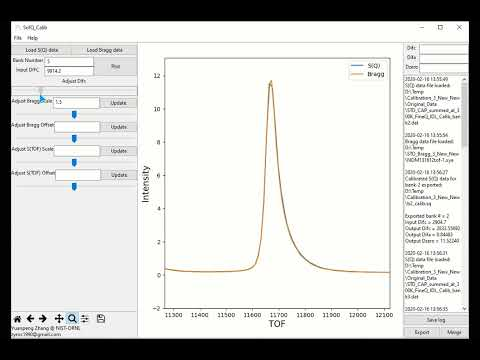

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('D8mY7k8MAIk', width=720, height=500)

### Usage

The usage of the calibration for powder TOF instruments (specifically, NOMAD and POWGEN in current scope) is two-fold, in line with the discussion presented in the sub-section above. On the Bragg side, the scenario is quite similar to that for CW instruments, i.e., the instrument parameter file containing the calibration constants will be delivered to genernal users. At the stage of data analysis, the main DIFC constant should be fixed and in most cases, the DIFA and TZERO values (and, potentially the DIFB parameter for POWGEN) can be released to be refined, to account for the potential sample position shift, etc.

On the total scattering side, although, as discussed in previous sub-section, the exact flying path, scattering angle, and among other engineering parameters (e.g., detector location) are still unknown after the calibration process, total scattering pattern with correct $Q$ (or $d$) assignment can still be constructed. However, as discussed in previous sub-section, the prerequisite condition for an accurate $Q$ or $d$ assignment is that the potential sample position shift as compared to the calibrant could be accounted properly. With this regard, a routine based on machine learning algorithm is being worked on, trying to solve the sample position shift as compared to the calibrant, by utilizing the relative position shift among pixels.